In [4]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
import numpy as np
from fonctions import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Récupération des images et préparation de la dataset

In [5]:
# Chemin vers le dossier principal contenant les sous-dossiers

main_folder = '../MMU-Iris-Database/'
# img_dim = (240, 320, 3)

In [6]:
def get_data_labels(main_folder):

    """Fais un jeu de données sur MMU-Iris-Database avec en target ["left", "right"]"""

    X = []
    y = []

    for target_folder in os.listdir(main_folder):
        target_path = os.path.join(main_folder, target_folder)
        if os.path.isdir(target_path):
            for folder in os.listdir(target_path): # Pour fichier dans 1, 2, 3... (gauche / droite)
                side_path = os.path.join(target_path, folder)
                if os.path.isdir(side_path):
                    for image_filename in os.listdir(side_path):
                        if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                            image_path = os.path.join(side_path, image_filename)
                            target = folder # target = gauche ou droite
                            image = cv2.imread(image_path)
                            X.append(image)
                            y.append(target)
    return X, y

X, y = get_data_labels(main_folder)

In [7]:
X.shape

AttributeError: 'list' object has no attribute 'shape'

In [8]:
labelEnc = preprocessing.LabelEncoder()
y_enc = labelEnc.fit_transform(y)

In [9]:
import numpy

numpy.save(r'C:\VSCODE\iris\modeles\labelsencoder\classes.npy', labelEnc.classes_)

In [ ]:
# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = "nearest",
)

In [ ]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
def augment_dataset(X_train, y_train, nb_aug_imgs):
  
  """
  Retourne un ndarray d'images augmentées utilisant 'datagen' (l'instance
  de la classe ImageDataGenerator) et leurs labels associés.
  """

  # Convertit les ndarray en listes
  if isinstance(X_train, np.ndarray):
    X_train = X_train.tolist()
  if isinstance(y_train, np.ndarray):
    y_train = y_train.tolist()

  augmented_images = []
  augmented_labels = []

  for img, label in zip(X_train, y_train):
    # Ajoute une dimension supplémentaire au Tensor
    img = np.expand_dims(img, axis=0)
    # img = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)
    # Compte le nombre d'itérations de la boucle
    batches = 0
    # Applique le ImageDataGenerator à l'image
    augmented_images.append(img)
    augmented_labels.append(label)
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        batches += 1
        # Generer un nombre d'images puis sortir de la boucle
        if batches >= nb_aug_imgs:
          break

  augmented_images = np.array(augmented_images)
  print(augmented_images.shape)
  augmented_labels = np.array(augmented_labels)
  
  return augmented_images, augmented_labels

augmented_images, augmented_labels = augment_dataset(X_train, y_train, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


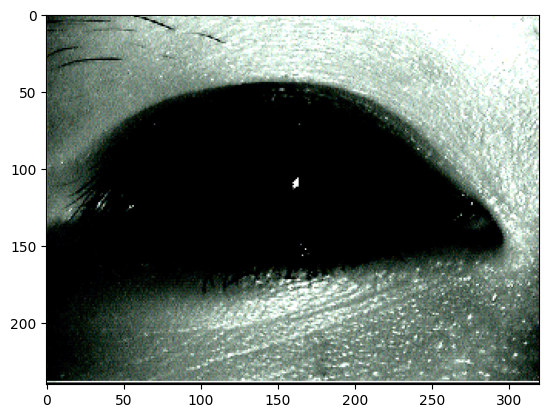

In [25]:
plt.imshow(X_train[0])

In [ ]:
i = 0
for batch in datagen.flow(X_train, y_train, batch_size=2):

    X_train.append(batch)
    i+= 1
    if i > 2:
        break

In [ ]:
X_train.shape

In [ ]:
X_train = datagen.flow(X_train, y_train_enc, batch_size = 2)
X_test = datagen.flow(X_test, y_test_enc, batch_size = 2)

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
NBCLASSES = 2
IMSIZE=[240,320]

def create_model():

    vgg = VGG16(input_shape = IMSIZE + [3], weights = 'imagenet', include_top = False)
 
    # Freeze existing VGG already trained weights 

    for layer in vgg.layers:

        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
    
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model
 
OG_model = create_model()

In [ ]:
hist = OG_model.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 2, validation_split = 0.25, callbacks = [rlrop, early, PlotLossesKeras()])

In [ ]:
# Exemple de données de test (remplacez cela par vos propres données)

y_test_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_test))]  # Prédictions du modèle

In [ ]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_test), np.array(y_test_pred))

# Calcul des mesures de performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred,average='macro')
recall = recall_score(y_test, y_test_pred,average='macro')
f1 = f1_score(y_test, y_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))
print(conf_matrix)